In [36]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def convert_to_boolean_labels(labels):
    return np.where(labels >= 0.5, True, False)

In [38]:
human_labels = [
 'toxicity',
 'severe_toxicity',
 'obscene',
 'sexual_explicit',
 'identity_attack',
 'insult',
 'threat',
 'male',
 'female',
 'transgender',
 'other_gender',
 'heterosexual',
 'homosexual_gay_or_lesbian',
 'bisexual',
 'other_sexual_orientation',
 'christian',
 'jewish',
 'muslim',
 'hindu',
 'buddhist',
 'atheist',
 'other_religion',
 'black',
 'white',
 'asian',
 'latino',
 'other_race_or_ethnicity',
 'physical_disability',
 'intellectual_or_learning_disability',
 'psychiatric_or_mental_illness',
 'other_disability']

identities = [
 'male',
 'female',
 'transgender',
 'other_gender',
 'heterosexual',
 'homosexual_gay_or_lesbian',
 'bisexual',
 'other_sexual_orientation',
 'christian',
 'jewish',
 'muslim',
 'hindu',
 'buddhist',
 'atheist',
 'other_religion',
 'black',
 'white',
 'asian',
 'latino',
 'other_race_or_ethnicity',
 'physical_disability',
 'intellectual_or_learning_disability',
 'psychiatric_or_mental_illness',
 'other_disability'
]
real_data_model_families = [['rock_toxicity'], ['rock_v6_1_toxicity']]

In [41]:
real_data = pd.read_csv('eval_datasets/identity_labeled_scored.csv')

In [43]:
for human_label in human_labels:
    real_data[human_label] = convert_to_boolean_labels(real_data[human_label])

In [44]:
short_real_data = real_data[(real_data.comment_text.str.len() < 100)]
print(len(real_data))
print(len(short_real_data))

1823017
480897


In [49]:
analysis_identities = []
drop_identities = []
for i in identities:
    if len(short_real_data[short_real_data[i]]) < 50:
        drop_identities.append(i)
    else: 
        analysis_identities.append(i)
drop_identities

['other_gender',
 'bisexual',
 'other_sexual_orientation',
 'hindu',
 'buddhist',
 'other_religion',
 'other_race_or_ethnicity',
 'physical_disability',
 'intellectual_or_learning_disability',
 'other_disability']

In [51]:
real_data_results = model_bias_analysis.per_subgroup_aucs(real_data, analysis_identities, real_data_model_families, 'toxicity')
short_real_data_results = model_bias_analysis.per_subgroup_aucs(short_real_data, analysis_identities, real_data_model_families, 'toxicity')

In [52]:
def unnest_list_column(df, column_name):
    new_col_name = column_name + '_flat'
    df[new_col_name] = df.apply(lambda row: row[column_name][0], axis=1)

def unnest_all_list_columns(df, metric_names, model_families):
    for metric in metric_names:
        for model_family in model_families:
            unnest_list_column(df, model_family[0] + metric)

metric_names = ['_aucs', '_normalized_pinned_aucs', '_within_negative_label_mwus', '_within_positive_label_mwus']

unnest_all_list_columns(real_data_results, metric_names, real_data_model_families)
unnest_all_list_columns(short_real_data_results, metric_names, real_data_model_families)

In [54]:
output_columns = ['subgroup',
 'subset_size',
 'rock_toxicity_aucs_flat',
 'rock_v6_1_toxicity_aucs_flat',
 'rock_toxicity_normalized_pinned_aucs_flat',
 'rock_v6_1_toxicity_normalized_pinned_aucs_flat',
 'rock_toxicity_within_negative_label_mwus_flat',
 'rock_v6_1_toxicity_within_negative_label_mwus_flat',
 'rock_toxicity_within_positive_label_mwus_flat',
 'rock_v6_1_toxicity_within_positive_label_mwus_flat']
out_real = real_data_results[output_columns]
out_real.to_csv('eval_datasets/identity_labeled_metrics.csv')
out_real_short = short_real_data_results[output_columns]
out_real_short.to_csv('eval_datasets/identity_labeled_metrics_short.csv')

In [90]:
def plot_histogram(data, identity, model, title, label_col='toxicity'):
    toxic_scores = data.query(identity + ' == True & ' + label_col + ' == True')[model]
    toxic_scores = toxic_scores.rename(title)
    non_toxic_scores = data.query(identity + ' == True & '+ label_col + ' == False')[model]
    non_toxic_scores = non_toxic_scores.rename(title)
    sns.distplot(non_toxic_scores , color="red", axlabel=title)
    sns.distplot(toxic_scores , color="blue", axlabel=title)
    plt.figure()

In [84]:
def plot_background_histogram(data, model, title, label_col='toxicity'):
    toxic_scores = data.query(label_col + ' == True')[model]
    toxic_scores = toxic_scores.rename(title)
    non_toxic_scores = data.query(label_col + ' == False')[model]
    non_toxic_scores = non_toxic_scores.rename(title)
    sns.distplot(non_toxic_scores , color="red", bins=30)
    sns.distplot(toxic_scores , color="blue", bins=30)
    plt.figure()

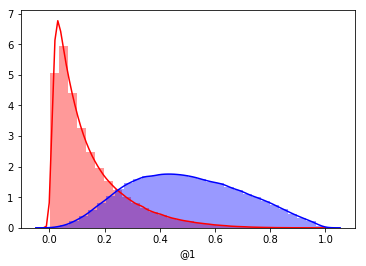

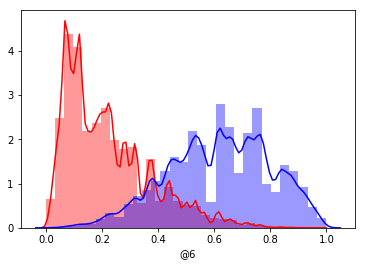

In [85]:
plot_background_histogram(real_data, 'rock_toxicity', '@1')
plot_background_histogram(real_data, 'rock_v6_1_toxicity', "@6")

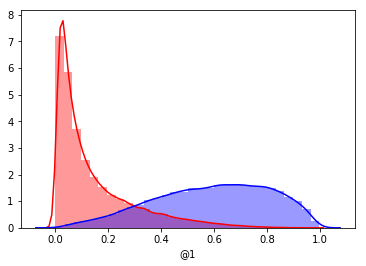

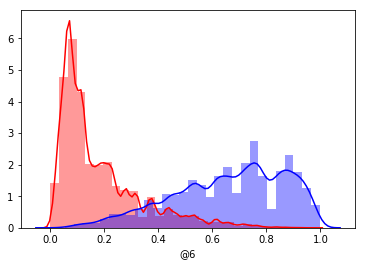

In [86]:
plot_background_histogram(short_real_data, 'rock_toxicity', '@1')
plot_background_histogram(short_real_data, 'rock_v6_1_toxicity', "@6")

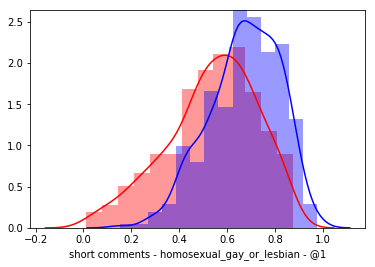

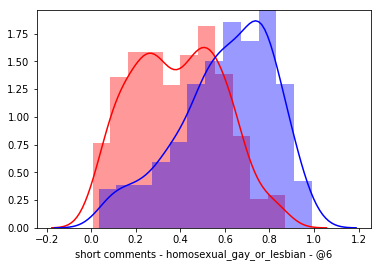

In [94]:
plot_histogram(short_real_data, 'homosexual_gay_or_lesbian', 'rock_toxicity', 'short comments - homosexual_gay_or_lesbian - @1')
plot_histogram(short_real_data, 'homosexual_gay_or_lesbian', 'rock_v6_1_toxicity', "short comments - homosexual_gay_or_lesbian - @6")

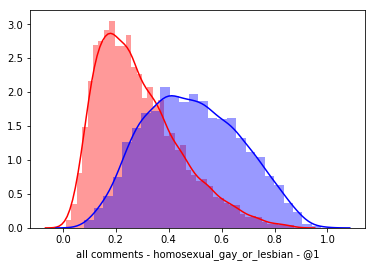

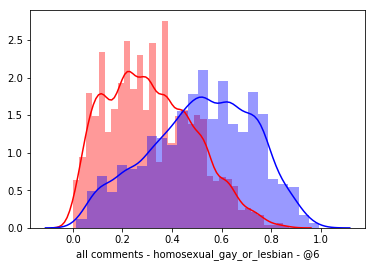

In [95]:
plot_histogram(real_data, 'homosexual_gay_or_lesbian', 'rock_toxicity', 'all comments - homosexual_gay_or_lesbian - @1')
plot_histogram(real_data, 'homosexual_gay_or_lesbian', 'rock_v6_1_toxicity', "all comments - homosexual_gay_or_lesbian - @6")